In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')


### Dynamic

In [2]:
print(f"Delta V = {np.mean([18.0, 19.0, 19.0, 36.0/2, 36.0/2, 36.0/2])}")


Delta V = 18.333333333333332


### Static

U=4           U=6            U=8       
       U      I      U       I      U      I
0   0.00   1.87   0.00    0.00   0.00   0.00
1   2.62  14.35   2.55    4.60   2.54   0.00
2   4.80  27.08   4.91   17.46   5.09   7.92
3   7.48  46.40   7.57   35.92   7.47  21.41
4   9.86  60.89  10.00   52.38  10.00  40.35
..   ...    ...    ...     ...    ...    ...
59   NaN    NaN  47.30  112.32    NaN    NaN
60   NaN    NaN  48.20  113.52    NaN    NaN
61   NaN    NaN  48.95  115.60    NaN    NaN
62   NaN    NaN  49.65  117.47    NaN    NaN
63   NaN    NaN  50.40  120.00    NaN    NaN

[64 rows x 6 columns]

[19.14 38.29]
[19.81 38.89]
[19.91 38.69]
[19.14 19.15 19.81 19.08 19.91 18.78]
V_max = (19.31 +- 0.41) В


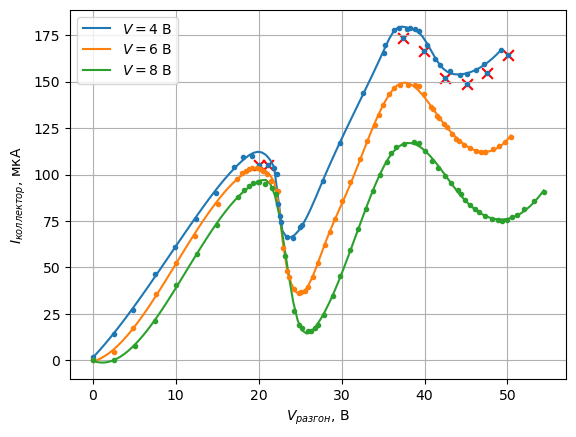

In [3]:
from scipy.signal import argrelmin, argrelmax

static = mipt.read_excel('data/521.xlsx', usecols=('A', 'B', 'D', 'E', 'G', 'H'), header=(0,1)).dropna(how='all')
display(static)

V_max_arr = []
def process(data, voltage, exclude = []):
    data = data.dropna()

    # Sort values
    data = list(zip(data['U'], data['I']))
    data.sort(key=lambda x: x[0])
    x, y = zip(*data)
    x = np.array(x)
    y = np.array(y)

    # Draw plot
    def interp(x, y):
        return UnivariateSpline(x, y)
    mipt.plot(x, y, func=interp, exclude=exclude, label=f'$V = {voltage}$ В')

    # Find extrema
    x = np.delete(x, exclude)
    y = np.delete(y, exclude)
    extr_max = argrelmax(y, order=4)[0]
    extr_min = argrelmin(y, order=4)[0]

    # Evaluate differences between maxima
    V_max = np.take(x, extr_max)
    print(V_max)
    V_max_arr.append([V_max[0], V_max[1] - V_max[0]])

process(static['U=4'], '4', exclude=[10, 11, 28, 33, 37, 40, 44, 46])
process(static['U=6'], '6')
process(static['U=8'], '8')

V_max_arr = np.array(V_max_arr).flatten()
print(V_max_arr)

V_max = np.mean(V_max_arr)
V_max_err = np.linalg.norm(V_max_arr - V_max) / np.sqrt(len(V_max_arr))
print(f"V_max = ({V_max:.2f} +- {V_max_err:.2f}) В")

plt.xlabel(r'$V_{разгон}$, В')
plt.ylabel(r'$I_{коллектор}$, мкА')
plt.legend()
plt.grid()
plt.savefig('gen/static.pdf')


In [4]:
keys=[r'U=4', r'U=6', r'U=8']

def get_fmt(voltage):
    key = f'U={voltage}'
    head = f'$V = {voltage}$ В'
    fmt = {
        key        : [head, '{:.0f}'],
        (key, 'U') : [r'$V_{\text{разгон}}$, В',  '{:.2f}'],
        (key, 'I') : [r'$I_{\text{коллектор}}$, мкА',  '{:.1f}'],
    }

    return fmt

fmt = get_fmt('4') | get_fmt('6') | get_fmt('8')
display(fmt)
table = mipt.table(static, fmt)
table.to_latex('gen/data.tex', na_rep='')
table.rename().get_data()


{'U=4': ['$V = 4$ В', '{:.0f}'],
 ('U=4', 'U'): ['$V_{\\text{разгон}}$, В', '{:.2f}'],
 ('U=4', 'I'): ['$I_{\\text{коллектор}}$, мкА', '{:.1f}'],
 'U=6': ['$V = 6$ В', '{:.0f}'],
 ('U=6', 'U'): ['$V_{\\text{разгон}}$, В', '{:.2f}'],
 ('U=6', 'I'): ['$I_{\\text{коллектор}}$, мкА', '{:.1f}'],
 'U=8': ['$V = 8$ В', '{:.0f}'],
 ('U=8', 'U'): ['$V_{\\text{разгон}}$, В', '{:.2f}'],
 ('U=8', 'I'): ['$I_{\\text{коллектор}}$, мкА', '{:.1f}']}

$V = 4$ В                                          $V = 6$ В  \
   $V_{\text{разгон}}$, В $I_{\text{коллектор}}$, мкА $V_{\text{разгон}}$, В   
0                    0.00                        1.87                   0.00   
1                    2.62                       14.35                   2.55   
2                    4.80                       27.08                   4.91   
3                    7.48                       46.40                   7.57   
4                    9.86                       60.89                  10.00   
..                    ...                         ...                    ...   
59                    NaN                         NaN                  47.30   
60                    NaN                         NaN                  48.20   
61                    NaN                         NaN                  48.95   
62                    NaN                         NaN                  49.65   
63                    NaN                         NaN                  50.40   

                                            $V = 8$ В  \
   $I_{\text{коллектор}}$, мкА $V_{\text{разгон}}$, В   
0                         0.00                   0.00   
1                         4.60                   2.54   
2                        17.46                   5.09   
3                        35.92                   7.47   
4                        52.38                  10.00   
..                         ...                    ...   
59                      112.32                    NaN   
60                      113.52                    NaN   
61                      115.60                    NaN   
62                      117.47                    NaN   
63                      120.00                    NaN   

                                
   $I_{\text{коллектор}}$, мкА  
0                         0.00  
1                         0.00  
2                         7.92  
3                        21.41  
4                        40.35  
..                         ...  
59                         NaN  
60                         NaN  
61                         NaN  
62                         NaN  
63                         NaN  

[64 rows x 6 columns]